In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [138]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [6]:
import yfinance as yf

In [222]:
GSPC = yf.download('^GSPC ')['Adj Close']
GSPC.index = pd.to_datetime(GSPC.index)

[*********************100%***********************]  1 of 1 completed


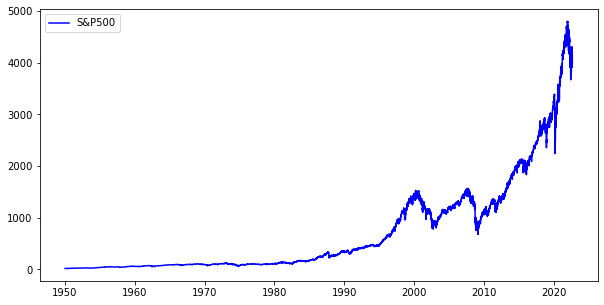

In [223]:
plt.figure(figsize=(10,5))
plt.plot(GSPC,c='blue',label='S&P500')
plt.legend()
plt.show()

For stationarity, we log differentiate the price of S&P500.

In [224]:
log_GSPC = np.log(GSPC)/np.log(GSPC.shift(1)).dropna() - 1

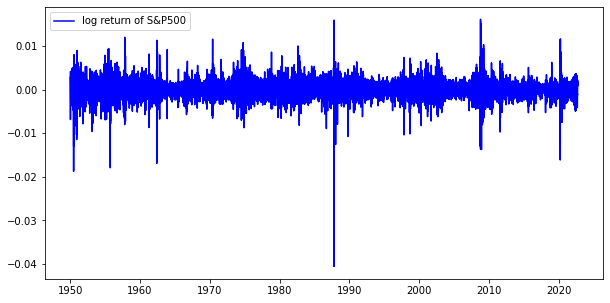

In [225]:
plt.figure(figsize=(10,5))
plt.plot(log_GSPC,c='blue',label='log return of S&P500')
plt.legend()
plt.show()

Define the variables for Hidden Markov Model

In [947]:
N = 2
M = 4
# Initial State Probabilities
# We assume multinomial distribution with 2 different outcomes initialized with 0.5
Pi = np.random.rand(N)
Pi = Pi/Pi.sum()
Pi

array([0.74523585, 0.25476415])

In [948]:
# Transition probabilities
# We define trainsion probability matrix with 2x2 dataframe initialized with 0.5
tp = np.random.rand(N,N)
#tp = tp/tp.sum(axis=1)
tmp_array = np.ones((N,N))
for n in range(0,N):
    tmp_array[n] = (tp[n]/tp[n].sum())
Transition_prob = pd.DataFrame(tmp_array)
Transition_prob

,0,1
0,0.516648,0.483352
1,0.914716,0.085284


In [949]:
# Emission probabilities
# We define emission probability matrix with 2X4 dataframe initialized with 0.25
ep = np.random.rand(N,M)
tmp_array = np.ones((N,M))
for n in range(0,N):
        tmp_array[n] = (ep[n]/ep[n].sum())
Emission_prob = pd.DataFrame(tmp_array)
Emission_prob

,0,1,2,3
0,0.321392,0.275209,0.336645,0.066755
1,0.234745,0.307614,0.175302,0.282339


In [950]:
# Log return data are binned.
# Thus, our Hidden Markov Model models 2 latent state and 4 outcomes.
def my_binning(x):
    if x>=0.0025:
        return 0
    elif (x<0.0025) and (x>=0):
        return 1
    elif (x<0) and (x>=-0.0025):
        return 2
    else:
        return 3

In [1115]:
binned_log_return = log_GSPC.apply(my_binning)[:500]
binned_log_return.index = range(0,len(binned_log_return))
binned_log_return

0      3
1      0
2      1
3      1
4      1
      ..
495    0
496    1
497    1
498    1
499    1
Name: Adj Close, Length: 500, dtype: int64

In [932]:
def get_forward_prob(Pi, Transition_prob, Emission_prob, N, binned_log_return):
    forward_prob = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=[num for num in range(0,N)])
    for time_step in forward_prob.index:
        if time_step == 0:
            for state in forward_prob.columns:
                forward_prob[state][time_step] = Pi[state] * Emission_prob[binned_log_return[time_step]][state]
        elif time_step >0:
            for state in forward_prob.columns:
                forward_prob[state][time_step] = Emission_prob[binned_log_return[time_step]][state] * (forward_prob.iloc[time_step-1,:].astype(float) * Transition_prob[state][:]).sum()
    return forward_prob

In [933]:
def get_backward_prob(Pi, Transition_prob, Emission_prob, N, binned_log_return):
    backward_prob = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=[num for num in range(0,N)])
    for time_step in backward_prob.index:
        if time_step == 0: # time_step 0 == T
            for state in backward_prob.columns:
                backward_prob[state][time_step] = 1
        elif time_step >0:
            for state in backward_prob.columns:
                backward_prob[state][time_step] = ( (Transition_prob.iloc[state,:].astype(float) * backward_prob.iloc[time_step-1,:].astype(float) * Emission_prob[binned_log_return[time_step-1]]).sum() )

    backward_prob.index = backward_prob.index[::-1]
    return backward_prob

In [934]:
def ViterbiDecoding(Pi, Transition_prob, Emission_prob, N, binned_log_return):
    delta = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=[num for num in range(0,N)])
    # Delta is the hightes probability along a single path, at time t, which accounts for the first t observations and ends in a certain state i.
    # Trace is the previous state of certain Delta.
    trace = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=[num for num in range(0,N)])
    for time_step in delta.index:
        if time_step == 0:
            for state in delta.columns:
                delta[state][time_step] = Pi[state] * Emission_prob[binned_log_return[time_step]][state]
                trace[state][time_step] = 0
        elif time_step > 0:
            for state in delta.columns:
                tmp_max = delta.iloc[time_step-1,:].astype(float) * Transition_prob.iloc[:,state].astype(float)
                delta[state][time_step] = max ( tmp_max ) * Emission_prob[binned_log_return[time_step]][np.argmax(tmp_max)]
                trace[state][time_step] = np.argmax(tmp_max)

    T = delta.iloc[-1,:].astype(float)        
    best_score = max ( T ) 
    Best_path = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=['Best_path'])
    for time_step in Best_path.index:
        if time_step == 0:
            Best_path['Best_path'][time_step] = np.argmax(T)
        elif time_step > 0:
            predecessor = Best_path['Best_path'][time_step-1]
            Best_path['Best_path'][time_step] = trace.iloc[time_step,predecessor]
    Best_path.index = Best_path.index[::-1]
    
    return delta, trace, Best_path

In [1103]:
def Maximization_step(Pi, Transition_prob, Emission_prob, N, binned_log_return, M, forward_prob, backward_prob):
    Xi = pd.DataFrame(index=[num for num in range(0,len(binned_log_return))], columns=[(num,num2) for num in range(0,N) for num2 in range(0,N)])
    for time_step in Xi.index:
        if time_step == len(Xi.index)-1:
            continue
        for col in Xi.columns:
            t_state , t_next_state = col[0], col[1]
            joint_prob = forward_prob.iloc[time_step,t_state].astype(float) * Transition_prob.iloc[t_state,t_next_state] * Emission_prob.iloc[t_next_state,binned_log_return[time_step+1]] * backward_prob.loc[time_step+1,t_next_state]
            Xi[col][time_step] = joint_prob
    for row in Xi.index:
        if row == len(binned_log_return)-1:
            pass
        else:
            Xi.loc[row,:] = Xi.loc[row,:] / Xi.sum(axis=1)[row]
     
    joint = forward_prob * backward_prob
    for row in joint.index:
        joint.loc[row,:] = joint.loc[row,:] / joint.sum(axis=1)[row]
    Gamma = joint
    Pi_new = Gamma.iloc[0,:].astype(float)
    
    expected_number_of_transition = Gamma.iloc[0:-1,:].sum(axis=0)
    Transition_prob_new = np.array(Xi.sum(axis=0)).reshape(N,N).astype(float)
    for n in range(0,N):
        Transition_prob_new[n] = Transition_prob_new[n]/expected_number_of_transition[n]

    Emission_prob_new = np.zeros((N,M))
    for v in range(0,M):
        tmp_index = binned_log_return.where(binned_log_return == v).dropna().values.tolist()
        for state in range(0,N):
            Emission_prob_new[state,v]+= Gamma[state][tmp_index].sum()
    for n in range(0,N):
        Emission_prob_new[n] = Emission_prob_new[n]/Emission_prob_new[n].sum()
    return Pi_new, pd.DataFrame(Transition_prob_new), pd.DataFrame(Emission_prob_new)

In [1104]:
def BaumWelch(Pi, Transition_prob, Emission_prob, N, M, binned_log_return, rep):
    forward_prob = get_forward_prob(Pi, Transition_prob, Emission_prob, N, binned_log_return)
    backward_prob = get_backward_prob(Pi, Transition_prob, Emission_prob, N, binned_log_return)
    delta, trace, Best_path = ViterbiDecoding(Pi, Transition_prob, Emission_prob, N, binned_log_return)
    Pi_new, Transition_prob_new, Emission_prob_new = Maximization_step(Pi, Transition_prob, Emission_prob, N, binned_log_return, M, forward_prob, backward_prob)
    for cnt in range(0,rep-1):
        print(f"{cnt+2} iterated.")
        forward_prob_new = get_forward_prob(Pi_new, Transition_prob_new, Emission_prob_new, N, binned_log_return)
        backward_prob_new = get_backward_prob(Pi_new, Transition_prob_new, Emission_prob_new, N, binned_log_return)
        delta, trace, Best_path = ViterbiDecoding(Pi_new, Transition_prob_new, Emission_prob_new, N, binned_log_return)
        Pi_new, Transition_prob_new, Emission_prob_new = Maximization_step(Pi_new, Transition_prob_new, Emission_prob_new, N, binned_log_return, M, forward_prob_new, backward_prob_new)
    
    return Pi_new, Transition_prob_new, Emission_prob_new, Best_path

In [1116]:
Pi_new, Transition_prob_new, Emission_prob_new, Best_path = BaumWelch(Pi, Transition_prob, Emission_prob, N, M, binned_log_return, 20)

2 iterated.
3 iterated.
4 iterated.
5 iterated.
6 iterated.
7 iterated.
8 iterated.
9 iterated.
10 iterated.
11 iterated.
12 iterated.
13 iterated.
14 iterated.
15 iterated.
16 iterated.
17 iterated.
18 iterated.
19 iterated.
20 iterated.


In [1117]:
Pi

array([0.74523585, 0.25476415])

In [1118]:
Pi_new

0    0.657475
1    0.342525
Name: 0, dtype: float64

In [1119]:
Transition_prob

,0,1
0,0.516648,0.483352
1,0.914716,0.085284


In [1120]:
Transition_prob_new

,0,1
0,0.528312,0.471688
1,0.905452,0.094548


In [1121]:
Emission_prob

,0,1,2,3
0,0.321392,0.275209,0.336645,0.066755
1,0.234745,0.307614,0.175302,0.282339


In [1122]:
Emission_prob_new

,0,1,2,3
0,0.181999,0.397994,0.308004,0.112003
1,0.182002,0.398011,0.307992,0.111995


In [1131]:
Best_path.index = log_GSPC[:500].index[::-1]
Best_path

,Best_path
Date,
1952-01-03,0
1952-01-02,0
1951-12-31,1
1951-12-28,0
1951-12-27,1
...,...
1950-01-09,0
1950-01-06,0
1950-01-05,0


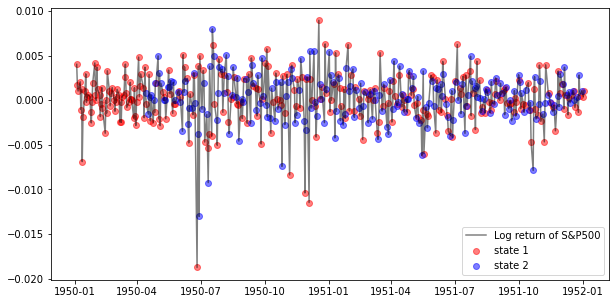

In [1145]:
plt.figure(figsize=(10,5))
plt.plot(log_GSPC[:500], label='Log return of S&P500', c ='black', alpha=0.5)
plt.scatter(x = log_GSPC[:500][Best_path['Best_path'] == 0].index, y = log_GSPC[:500][Best_path['Best_path'] == 0], label='state 1', c ='red', alpha=0.5)
plt.scatter(x = log_GSPC[:500][Best_path['Best_path'] == 1].index, y = log_GSPC[:500][Best_path['Best_path'] == 1], label='state 2', c ='blue', alpha=0.5)
plt.legend()